# Mini Project: Recommendation Engines

Recommendation engines are algorithms designed to provide personalized suggestions or recommendations to users. These systems analyze user behavior, preferences, and interactions with items (products, movies, music, articles, etc.) to predict and offer items that users are likely to be interested in. Recommendation engines play a crucial role in enhancing user experience, driving engagement, and increasing conversion rates in various applications, including e-commerce, entertainment, content platforms, and more.

There are generally two approaches taken in collaborative filtering and content-based recommendation engines:

**1. Collaborative Filtering:**
Collaborative Filtering is a popular approach to building recommendation systems that leverages the collective behavior of users to make personalized recommendations. It is based on the idea that users who have agreed in the past will likely agree in the future. There are two main types of collaborative filtering:

- **User-based Collaborative Filtering:** This method finds users similar to the target user based on their past interactions (e.g., ratings or purchases). It then recommends items that similar users have liked but the target user has not interacted with yet.

- **Item-based Collaborative Filtering:** In this approach, the system identifies similar items based on user interactions. It recommends items that are similar to the ones the target user has already liked or interacted with.

Collaborative filtering does not require any explicit information about items but relies on the similarity between users or items. It is effective in capturing complex patterns and can provide serendipitous recommendations. However, it suffers from the cold-start problem (i.e., difficulty in recommending to new users or items with no interactions) and scalability challenges in large datasets.

**2. Content-Based Recommendation:**
Content-based recommendation is an alternative approach to building recommendation systems that focuses on the attributes or features of items and users. It leverages the characteristics of items to make recommendations. The key steps involved in content-based recommendation are:

- **Feature Extraction:** For each item, relevant features are extracted. For movies, these features could be genre, director, actors, and plot summary.

- **User Profile:** A user profile is created based on the items they have interacted with in the past. The user profile contains the weighted importance of features based on their interactions.

- **Similarity Calculation:** The similarity between items or between items and the user profile is calculated using similarity metrics like cosine similarity or Euclidean distance.

- **Recommendation:** Items that are most similar to the user profile are recommended to the user.

Content-based recommendation systems are less affected by the cold-start problem as they can still recommend items based on their features. They are also more interpretable as they rely on item attributes. However, they may miss out on providing serendipitous recommendations and can be limited by the quality of feature extraction and user profiles.

**Choosing Between Collaborative Filtering and Content-Based:**
Both collaborative filtering and content-based approaches have their strengths and weaknesses. The choice between them depends on the specific requirements of the recommendation system, the type of data available, and the user base. Hybrid approaches that combine collaborative filtering and content-based techniques are also common, aiming to leverage the strengths of both methods and mitigate their weaknesses.

In this mini-project, you'll be building both content based and collaborative filtering engines for the [MovieLens 25M dataset](https://grouplens.org/datasets/movielens/25m/). The MovieLens 25M dataset is one of the most widely used and popular datasets for building and evaluating recommendation systems. It is provided by the GroupLens Research project, which collects and studies datasets related to movie ratings and recommendations. The MovieLens 25M dataset contains movie ratings and other related information contributed by users of the MovieLens website.

**Dataset Details:**
- **Size:** The dataset contains approximately 25 million movie ratings.
- **Users:** It includes ratings from over 162,000 users.
- **Movies:** The dataset consists of ratings for more than 62,000 movies.
- **Ratings:** The ratings are provided on a scale of 1 to 5, where 1 is the lowest rating and 5 is the highest.
- **Timestamps:** Each rating is associated with a timestamp, indicating when the rating was given.

**Data Files:**
The dataset is usually split into three CSV files:

1. **movies.csv:** Contains information about movies, including the movie ID, title, genres, and release year.
   - Columns: movieId, title, genres

2. **ratings.csv:** Contains movie ratings provided by users, including the user ID, movie ID, rating, and timestamp.
   - Columns: userId, movieId, rating, timestamp

3. **tags.csv:** Contains user-generated tags for movies, including the user ID, movie ID, tag, and timestamp.
   - Columns: userId, movieId, tag, timestamp

First, import all the libraries you'll need.

In [257]:
import zipfile
import numpy as np
import pandas as pd
from urllib.request import urlretrieve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import random

Next, download the relevant components of the MoveLens dataset. Note, these instructions are roughly based on the colab [here](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=O3bcgduFo4s6).

In [3]:
print("Downloading movielens data...")

urlretrieve('http://files.grouplens.org/datasets/movielens/ml-100k.zip', 'movielens.zip')
zip_ref = zipfile.ZipFile('movielens.zip', 'r')
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


Before doing any kind of machine learning, it's always good to familiarize yourself with the datasets you'lll be working with.

Here are your tasks:

1. Spend some time familiarizing yourself with both the `movies` and `ratings` dataframes. How many unique user ids are present? How many unique movies are there?
2. Create a new dataframe that merges the `movies` and `ratings` tables on 'movie_id'. Only keep the 'user_id', 'title', 'rating' fields in this new dataframe.

In [4]:
print(movies.head())
print(ratings.head())# Spend some time familiarizing yourself with both the movies and ratings
# dataframes. How many unique user ids are present? How many unique movies are there?
nUsers = ratings['user_id'].unique().size
print(f'\n no: of users: {nUsers}')
nMovies = ratings['movie_id'].unique().size
print(f'\n no: of movies: {nMovies}')

   movie_id              title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
4         5     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  genre_unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...              0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...              0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...              0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...              0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)              0       0   

   Adventure  Animation  Children  ...  Fantasy  Film-Noir  Horror  Musical  \
0          0          1         1  ...     

In [5]:
merged_df = pd.merge(movies, ratings, on='movie_id')
merged_df.head()
print(merged_df.head())# Merge movies and ratings dataframes

   movie_id             title release_date  video_release_date  \
0         1  Toy Story (1995)  01-Jan-1995                 NaN   
1         1  Toy Story (1995)  01-Jan-1995                 NaN   
2         1  Toy Story (1995)  01-Jan-1995                 NaN   
3         1  Toy Story (1995)  01-Jan-1995                 NaN   
4         1  Toy Story (1995)  01-Jan-1995                 NaN   

                                            imdb_url  genre_unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...              0       0   
1  http://us.imdb.com/M/title-exact?Toy%20Story%2...              0       0   
2  http://us.imdb.com/M/title-exact?Toy%20Story%2...              0       0   
3  http://us.imdb.com/M/title-exact?Toy%20Story%2...              0       0   
4  http://us.imdb.com/M/title-exact?Toy%20Story%2...              0       0   

   Adventure  Animation  Children  ...  Musical  Mystery  Romance  Sci-Fi  \
0          0          1         1  ...        0    

As mentioned in the introduction, content-Based Filtering is a recommendation engine approach that focuses on the attributes or features of items (products, movies, music, articles, etc.) and leverages these features to make personalized recommendations. The underlying idea is to match the characteristics of items with the preferences of users to suggest items that align with their interests. Content-based filtering is particularly useful when explicit user-item interactions (e.g., ratings or purchases) are sparse or unavailable.

**Key Steps in Content-Based Filtering:**

1. **Feature Extraction:**
   - For each item, relevant features are extracted. These features are typically descriptive attributes that can be represented numerically, such as genre, director, actors, author, publication date, and keywords.
   - In the case of text-based items, natural language processing techniques may be used to extract features like TF-IDF (Term Frequency-Inverse Document Frequency) scores.

2. **User Profile Creation:**
   - A user profile is created based on the items they have interacted with in the past. The user profile contains the weighted importance of features based on their interactions.
   - For example, if a user has watched several action movies, the action genre feature would receive a higher weight in their profile.

3. **Similarity Calculation:**
   - The similarity between items or between items and the user profile is calculated using similarity metrics like cosine similarity, Euclidean distance, or Pearson correlation.
   - Cosine similarity is commonly used as it measures the cosine of the angle between two vectors, which represents their similarity.

4. **Recommendation:**
   - Items that are most similar to the user profile are recommended to the user. These are items whose features have the highest similarity scores with the user profile.
   - The recommended items are presented as a list sorted by their similarity scores.

**Advantages of Content-Based Filtering:**
1. **No Cold-Start Problem:** Content-based filtering can make recommendations even for new users with no historical interactions because it relies on item features rather than user history.

2. **User Independence:** The recommendations are based solely on the features of items and do not require knowledge of other users' preferences or behavior.

3. **Transparency:** Content-based recommendations are interpretable, as they depend on the features of items, making it easier for users to understand why specific items are recommended.

4. **Serendipity:** Content-based filtering can recommend items with characteristics not seen before by the user, leading to serendipitous discoveries.

5. **Diversity in Recommendations:** The method can offer diverse recommendations since it suggests items with different feature combinations.

**Limitations of Content-Based Filtering:**
1. **Limited Discovery:** Content-based filtering may struggle to recommend items outside the scope of users' historical interactions or interests.

2. **Over-Specialization:** Users may receive recommendations that are too similar to their previous choices, leading to a lack of exposure to new item categories.

3. **Dependency on Feature Quality:** The quality and relevance of item features significantly influence the quality of recommendations.

4. **Limited for Cold Items:** Content-based filtering can struggle to recommend new items with limited feature information.

Here is your task:

1. Write a function that takes in a user id and the dataframe you created before that contains 'user_id', 'title', and 'rating'. The function should return content-based recommendations for this user. Here are steps you can take:

  A. Get the user's rated movies

  B. Create a TF-IDF matrix using movie genres. Note, this can be extracted from the `movies` dataframe.

  C. Compute the cosine similarity between movie genres. Use the [cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) function.

  D. Get the indices of similar movies to those rated by the user based on cosine similarity. Keep only the top 5.

  E. Remove duplicates and movies already rated by the user.

In [211]:
# Content-Based Filtering using Movie Genres
def content_based_recommendation(user_id, df):
  # Get the user's rated movies
  result = {}
  user_movies = df[merged_df['user_id'] == user_id]
  user_movie_index = user_movies['title'].apply(lambda x: movies[movies['title'] == x].index[0]).tolist()
  umid = user_movies['movie_id'].tolist()

  #Create a TF-IDF matrix using movie genres. Note, this can be extracted from the movies dataframe.

  tfidf = TfidfTransformer()

  movie_genres = movies[genre_cols]
  tfidf_matrix = tfidf.fit_transform(movie_genres)

  #Compute the cosine similarity between movie genres. Use the cosine_similarity function.
  cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

  #Get the indices of similar movies to those rated by the user based on cosine similarity. Keep only the top 5 movies for each user_movie_index

  indices = cosine_sim[user_movie_index].argsort()
  similar_indices = indices[:, -5:]


  #Test code
  print(f'no: of movies rated by userId : {user_id} = {len(user_movie_index)}\n')
  print(f'printing first 10 movies rated by userId : {user_id} -- {user_movie_index[:10]}')
  print(f'\ncosine for 3rd movie with movie index: {user_movie_index[2:3]} : {cosine_sim[user_movie_index][2:3]}\n')
  first =cosine_sim[user_movie_index][2:3]
  sorted_indices = first.argsort()
  sorted_indices_descending = np.flip(sorted_indices)
  print(f'sorted cosine for 3rd movie: {sorted_indices} \n')
  print('\n---- last 5 values of the first 10 user_movies in cosines sorted ascending-------\n')
  print(indices[:10, -5:])



  #get the elements corresponding to sorted indices in descending order

  similar_movies = []
  present = []
  for i in range(similar_indices.shape[0]):
    similar_movies.append([])

  for i in range(similar_indices.shape[0]):
    movie_key = movies[movies.index == user_movie_index[i]]['title'].values[0]
    #print(movie_key)
    for j in range(similar_indices.shape[1]):
        index = similar_indices[i][j]

        # Check if the index is in the movies DataFrame
        if not np.isin(index, list(movies.index)):
            similar_movies[i].append(None)
        else:
            movie_id = movies[movies.index == index]['movie_id'].values[0]
            # Check if the movie_id is not in the user's rated movies
            if movie_id not in umid:
                m = movies[movies['movie_id'] == index]
                # Check if the DataFrame is not empty before accessing its elements
                if not m.empty:
                    movie_title = m['title'].values[0]  # Extract the title from the DataFrame
                    if movie_title not in present:
                      # Avoid duplicates
                      present.append(movie_title)
                      similar_movies[i].append(movie_title)

    result[movie_key] =  similar_movies[i]

  return result, present


In [260]:
result_map, result_list = content_based_recommendation(22, merged_df)
print(f'\nResult Map: {result_map} \n')
print(f'Result List: {result_list}')


no: of movies rated by userId : 22 = 128

printing first 10 movies rated by userId : 22 -- [1, 3, 16, 20, 23, 28, 49, 52, 61, 67]

cosine for 3rd movie with movie index: [16] : [[0.10801791 0.43694049 0.40701128 ... 0.         0.30913614 0.        ]]

sorted cosine for 3rd movie: [[1681  470 1084 ...  272  395   16]] 


---- last 5 values of the first 10 user_movies in cosines sorted ascending-------

[[ 565  929    1 1015 1104]
 [1180 1182  875   73    3]
 [ 306 1138  272  395   16]
 [1313  117  185  361   20]
 [  28  402  575  253   23]
 [  23  253  575  230   28]
 [ 497  270  171   49  180]
 [1547   78 1594  545  840]
 [ 227  228  229   61  448]
 [ 567   32 1088  750   67]]

Result Map: {'GoldenEye (1995)': ['Harriet the Spy (1996)', 'Shiloh (1997)', "C'est arrivé près de chez vous (1992)"], 'Get Shorty (1995)': ['I Love Trouble (1994)', 'Cops and Robbersons (1994)', "She's So Lovely (1997)", 'Maverick (1994)'], 'From Dusk Till Dawn (1996)': ['Mrs. Brown (Her Majesty, Mrs. Brown) (1

The key idea behind collaborative filtering is that users who have agreed in the past will likely agree in the future. Instead of relying on item attributes or user profiles, collaborative filtering identifies patterns of user behavior and item preferences from the interactions present in the data.

**Types of Collaborative Filtering:**
There are two main types of collaborative filtering:

**Collaborative Filtering Process:**
The collaborative filtering process typically involves the following steps:

1. **Data Collection:**
   - Gather data on user-item interactions, such as movie ratings, product purchases, or article clicks.

2. **User-Item Matrix:**
   - Organize the data into a user-item matrix, where rows represent users, columns represent items, and the entries contain the users' interactions (e.g., ratings).

3. **Similarity Calculation:**
   - Calculate the similarity between users or items using similarity metrics such as cosine similarity, Pearson correlation, or Jaccard similarity.
   - For user-based collaborative filtering, user similarities are calculated, and for item-based collaborative filtering, item similarities are calculated.

4. **Neighborhood Selection:**
   - For each user or item, select the most similar users or items as the neighborhood.
   - The size of the neighborhood (the number of similar users or items to consider) is an important parameter to control the system's behavior.

5. **Prediction Generation:**
   - Predict the ratings for items that the target user has not yet interacted with by combining the ratings of neighboring users or items.

6. **Recommendation Generation:**
   - Recommend items with the highest predicted ratings to the target user.

**Advantages of Collaborative Filtering using User-Item Interactions:**
- Collaborative filtering is based solely on user interactions and does not require knowledge of item attributes, making it useful for cases where item data is sparse or unavailable.
- It can provide serendipitous recommendations, suggesting items that users may not have discovered on their own.
- Collaborative filtering can be applied in various domains, including e-commerce, music, movie, and content recommendations.

**Limitations of Collaborative Filtering:**
- The cold-start problem: Collaborative filtering struggles to recommend to new users or items with no or limited interaction history.
- It may suffer from sparsity when data is limited or when users have only interacted with a small subset of items.
- Scalability issues can arise with large datasets and an increasing number of users or items.

Here is your task:

1. Write a function that takes in a user id and the dataframe you created before that contains 'user_id', 'title', and 'rating'. The function should return collaborative filtering recommendations for this user based on a user-item interaction matrix. Here are steps you can take:

  A. Create the user-item matrix using Pandas' [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html).

  B. Fill missing values with zeros in this matrix.

  C. Calculate user-user similarity matrix using cosine similarity.

  D. Get the array of similarity scores of the target user with all other users from the similarity matrix.

  E. Extract, say the the top 5 most similar users (excluding the target user).

  F. Generate movie recommendations based on the most similar users.

  G. Remove duplicate movies recommendations.

In [240]:
# Collaborative Filtering using User-Item Interactions
def collaborative_filtering_recommendation(user_id, df):
  # Create the user-item matrix
  user_item_matrix = df.pivot_table(index='user_id', columns='title', values='rating')
  # Fill missing values with 0 (indicating no rating)
  user_item_matrix = user_item_matrix.fillna(0)
  # Calculate user-user similarity matrix using cosine similarity
  user_similarity = cosine_similarity(user_item_matrix)
  # Get the array of similarity scores of the target user with all other users
  target_user_similarity = user_similarity[user_id - 1]
  # Find the top N most similar users (excluding the target user)
  top_similar_users_indices = np.argsort(target_user_similarity)[::-1][:6]
  top_similar_users = [user + 1 for user in top_similar_users_indices]
  print(f'top_similar_users:{top_similar_users}\n')
  top_similar_users = top_similar_users[1:]
  print(f'top_similar_users excluding self:{top_similar_users}\n')
  # Generate movie recommendations based on the most similar users

  #Find indices of movies not rated by user_id
  unrated_movies_indices = user_item_matrix.columns[user_item_matrix.loc[user_id] == 0].tolist()
  print(f'first 10 unrated_movies_indices for user-{user_id}:{sorted(unrated_movies_indices)[:10]}\n')

  recommendations = {}
  for user_index in top_similar_users:
    # Get top rated movies of user_index
    top_rated_movies_user_id = user_item_matrix.loc[user_index].sort_values(ascending=False).head(100).index.tolist()
    # Remove duplicates(already watched movies) from recommendations
    top_unrated_movies_user_id = [movie for movie in top_rated_movies_user_id if movie in unrated_movies_indices]
    print(f'Out of the top 100 movies rated by user-{user_index }, no: of movies unrated by user-{user_id} = {len(top_unrated_movies_user_id)}\n')
    recommendations[user_index] = top_unrated_movies_user_id
    print(f'top 10 sorted movies for user-{user_index } : {sorted(top_unrated_movies_user_id[:10])}\n')
  return recommendations

Now, test your recommendations engines! Select a few user ids and generate recommendations using both functions you've written. Are the recommendations similar? Do the recommendations make sense?

In [259]:
# Test the recommendation engines
r_map = collaborative_filtering_recommendation(22, merged_df)
r_list = sorted(set(item for sublist in r_map.values() for item in sublist))

print(f'\nResults map:{r_map} \n')
print(f'Results List:{r_list}')

top_similar_users:[22, 638, 746, 158, 648, 102]

top_similar_users excluding self:[638, 746, 158, 648, 102]

first 10 unrated_movies_indices for user-22:["'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)']

Out of the top 100 movies rated by user-638, no: of movies unrated by user-22 = 47

top 10 sorted movies for user-638 : ['Alien (1979)', 'Braveheart (1995)', 'Conan the Barbarian (1981)', 'Executive Decision (1996)', 'Fargo (1996)', 'Full Metal Jacket (1987)', 'Jaws (1975)', 'Kingpin (1996)', 'Psycho (1960)', 'Silence of the Lambs, The (1991)']

Out of the top 100 movies rated by user-746, no: of movies unrated by user-22 = 54

top 10 sorted movies for user-746 : ['Alien (1979)', 'Babe (1995)', 'Dead Poets Society (1989)', 'Demolition Man (1993)', 'Jurassic P

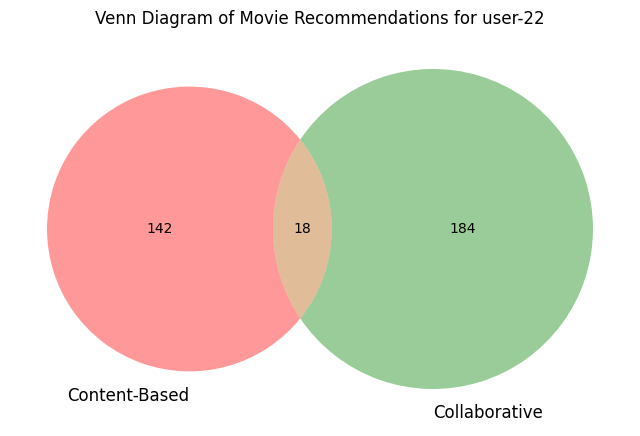

In [261]:
# Convert lists to sets for set operations
set1 = set(result_list)
set2 = set(r_list)

# Create a Venn diagram
plt.figure(figsize=(8, 8))
venn2([set1, set2], ('Content-Based', 'Collaborative'))

# Title and display the plot
plt.title('Venn Diagram of Movie Recommendations for user-22')
plt.show()


In [264]:
import os
# Generate a random list of 10 values from 1 to 1000
random_users = random.sample(range(1, 1001), 10)

# Lists to store the sets for content-based and collaborative filtering
content_based_sets = []
collab_filtering_sets = []

# Generate recommendations and extract unique movie IDs for each user
for user_id in random_users:
    with open(os.devnull, 'w') as devnull:
        sys.stdout = devnull  # Redirect print output to suppress inner function printouts
        content_map, _ = content_based_recommendation(user_id, merged_df)
        colab_map = collaborative_filtering_recommendation(user_id, merged_df)
        sys.stdout = sys.__stdout__  # Restore stdout
    # Flatten the dictionaries and extract unique movie IDs
    content_ids = set(item for sublist in content_map.values() for item in sublist)
    colab_ids = set(item for sublist in colab_map.values() for item in sublist)

    # Append to the lists of sets
    content_based_sets.append(content_ids)
    collab_filtering_sets.append(colab_ids)

# Create subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 25))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Titles for each subplot
titles = ['User ' + str(user_id) for user_id in random_users]

# Iterate over sets and create Venn diagrams
for i in range(10):
    set1 = content_based_sets[i]
    set2 = collab_filtering_sets[i]

    # Create a Venn diagram
    venn2([set1, set2], ('Content-Based', 'Collaborative Filtering'), ax=axs[i])

    # Title for the subplot
    axs[i].set_title(titles[i])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


NameError: name 'sys' is not defined